# Section 8: Power Spectra Part 2

This notebook can be used to generate an example power spectrum using Nawrapper, a Namaster wrapper.  For this section we use the maps that are presented in Aiola et al 2020 which are the maps of individual patches.  These maps include multiple splits along with the other products needed to generate power spectra from them.  In this example we walk through how to use nawrapper to generate a spectrum of ACT's D56 region. 

This code relies on maps dicussed in Aiola et al 2020 and techniques from Choi et al 2020, as such we ask that you reference those orginal works when using these data products or this code.

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to AdvACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps from [Naess et al. (2020)](https://www.overleaf.com/5395816498bsknshgxbmyr) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al. (2020)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_power_spectra_part_1.ipynb): Harmonic Analysis using CAR maps [Naess et al, in preparation]

> [Section 8](Section_8_power_spectra_part_2.ipynb) Power Spectrum example using Nawrapper [Aiola et al] and [Choi et al] 

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code
 
> [Section 12](Section_12_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020, in preparation]
---

## Accessing the available map splits

The season 13 through 16 maps cover ~ 17,000 sq degrees on the sky and we present both 98 GHz and 150 GHz maps. They include data used to make the maps presented in Naess et al. (2014) and Louis et al. (2017) along with sumplemental observations from 2015 and 2016. While we will only use the data from the D8 patch in this particular notebook, the rest of the patch, array, season and frequncy combinations are detailed in Table 1 and in [Aiola et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=ACT_DR4_A20_v20200420.pdf)

---
Table 1: Summary of patch sizes and white-noise levels
---



Season | s13|s14|s15|s16
---|---|---|---|---
**Array and Frequency** | **PA1$_{150}$** | **PA1$_{150}$/ PA2$_{150}$**|  **PA1$_{150}$**/ **PA2$_{150}$/PA3$_{98}$ / PA3$_{150}$**| **PA2/PA3$_{98}$/PA3$_{150}$**
**D1 (131 sq deg)**| 18.6 | | |
**D5 (157 sq deg)** | 16.4 
**D6 (135 sq deg)**| 12.6|
**D56 (834 sg deg)**| | 32.3/20.5 | 33.3/21.9/18.4/28.6|
**D8 (248 sq deg)**| | | 42.0/21.5/20.0/29.0|
**BN (3157 sq deg)**| | |76.8/41.3/33.9/49.1
**AA (17044 sq deg)** | | || 72.9/78.7/118.5

White noise levels are given in units of $\mu$K-arcmin.

---

For each of the patch, season, array and frequency combination we include 4 splits (with the exception of patch AA which includes 2) as well as one map-based co-add resulting in 94 data units.  

Each of these units contains 4 fits files:
 * Source-free maps:  These contain I (or T), Q and U Stokes components and are in units of $\mu K_{CMB}$ 
 * Source maps:  These contain the point-source signal in units of $\mu K_{CMB} $ .  The simple sum of the source and source-free maps will give a map of the observed sky.
 * ivar (inverse-variance) maps: Roughly proportional to a traditinoal hit count map but includes the variance contribution from detector noise and so is better suited for pixel weighting in map-based co-addition.
 * Cross-linking maps: T, Q, U components that are used to describe the pixel cross-linking of a dataset.  

---
Maps are named according to the convention:
> act_dr4.01_season\*\_patch\*\_array\*\_freq\*\_nohwp_night_3pass_set\*\_map_suffix\*

* Season: s13, s14, s15, s16
* patch: D1, D5, D6, D56, D8, BN, AA
* array: PA1, PA2, PA3
* freq: f090, f150
* set: 2way_set0, 2way_set1 or 4way_set(0 - 4)
* map_suffix: map_srcfree.fits, srcs.fits, xlink.fits, ivar.fits

Once the splits of interest have been chosen they can be read in and viewed using Pixell's enmap as shown in the following example.

For this example we use the D56 patch at 150 GHz.

### Set up the notebook and read in functions

As usual we begin by reading in the first notebook to set up our path and read in the functions.  We will also take a moment to import nawrapper and set up the plotting function we've been using throughout.

In [1]:
%run Section_1_Introduction.ipynb
import nawrapper as nw

# Redefine our plotting function from section 2
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

### Part 1: Loading the relevant maps

For this notebook we read in five files: the ell bins used for ACT power spectra, the beam file, the point source mask, the apodized patch footprint, and the inverse-variance map.

In [3]:
bin_file = "/BIN_ACTPOL_50_4_SC_low_ell" #"data/from_choi/binning
beam_file = "act_dr4.01_s14_pa1_f150_nohwp_night_beam_tform_jitter_D56_cmbspec.txt" #/ancillary_products/window_functions/beams/

psmask_file = "act_dr4.01_mask_s13s16_0.015mJy_5.0arcmin.fits" #/ancillary_products/masks/source_masks/
footprint_file = "act_dr4.01_D56_apo_w0.fits" 
ivar_file = "act_dr4.01_s14_D56_pa1_f150_nohwp_night_3pass_4way_coadd_ivar.fits" #/maps/s14


In [4]:
# normalize the beam
beam = nw.read_beam(path + beam_file)
beam /= beam[0]

We extract the shape and wcs of the footprint, to then ensure all the maps we use to compute the power spectrum have this same shape and wcs.

In [5]:
# read in the footprint
footprint = enmap.read_map(path + footprint_file)
shape,wcs = footprint.shape, footprint.wcs

# read in the point source mask, make sure it has the correct shape, and apodize
psmask = enmap.extract(enmap.read_map(path + psmask_file), shape, wcs)
psmask = nw.apod_C2(psmask, 18./60.)

# read in the coadd inverse variance map and make sure it has the correct shape
ivar = enmap.extract(enmap.read_map(path + ivar_file), shape, wcs)

mask = footprint*psmask*ivar

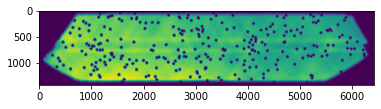

In [22]:
# We can plot the final mask quickly to look at it 
plt.imshow(mask)

Our final mask is made up of the apodized footprint corresponding to the region of sky (D56) we want to study, an apodized point source mask, and the area is weighted by the inverse variance of the coadded map.

Next, we load in the maps. In this example, the same mask is used to speed up the spectra calculation, but in general each map will have a different mask.

We correct for the pixel window function and apply the k-space filter using `preprocess_fourier`, with $|k_x| < 90$ and $|k_y| < 50$. The `preprocess_fourier` function will also call `enmap.extract` if you pass it `shape` and `wcs` information, in order to conform all the maps to the same geometry. If you load in a source map for example, you'll want to run `enmap.extract` on it in order to get it to have the same shape and WCS as everything else.

There is a particular flag here, `legacy_steve = True`. It turns out that the code used in Choi 2020 applied a slightly incorrect k-space filter, and offset the maps by (-1,-1) in `WCS.CRPIX`. This has no significant effect on the final results.


In [6]:
mapname_head = f"{dr4_products}/maps/s14/act_dr4.01_s14_D56_pa1_f150_nohwp_night_3pass_4way_set"

# loop over splits and generate namap_list
nsplits = 4

namap_list = []
for i in range(nsplits):
    
    # read source-free map from disk and preprocess (i.e. k-space filter and pixwin)
    maps = enmap.read_map(f"{mapname_head}{i}_map_srcfree.fits")
    maps = enmap.extract(maps,shape,wcs)
    map_I = nw.preprocess_fourier(maps[0], shape, wcs, legacy_steve=True)
    
    # add in the sources
    source_map = enmap.read_map(f"{mapname_head}{i}_srcs.fits")
    source_map = enmap.extract(source_map,shape,wcs)
    map_I = map_I + source_map[0]
    
    # create the namap_car, to bundle maps/masks/beams together
    split_namap = nw.namap_car(
        maps=map_I,
        masks=mask, 
        beams=beam)
    namap_list.append(split_namap)

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: False
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: False
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: False
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: False
Computing spherical harmonics.



The polarization components of the maps can also be included in the step above to compute the TE and EE spectra by specifying `map_Q` and `map_U`. This results in a longer computation time. For the polarization components a different beam and mask may be specified. 

### Computing the Mode Coupling Matrix


The cell below takes the longest time to compute. If the last cell took a few minutes to execute for you, now would be a good time to go make a cup of tea and perhaps reply to some emails, take a walk, or read a book.

In [28]:
bins = nw.read_bins(bin_file, is_Dell=True)
mc = nw.mode_coupling(namap_list[0], namap_list[1], bins)

Computing new mode-coupling matrices.


### Computing Spectra


Next, we apply the mode coupling matrix to each pair of namap objects. We will reuse the mode coupling object we computed, since all the masks are the same in this toy example. We take a flat mean of the 4 choose 2 = 6 cross spectra, and also compute the standard error.


In [8]:
spec_dict = {}
TT_cross_spectra = []

# we use the mode coupling matrix `mc` from earlier
for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                namap_list[i], namap_list[j], mc=mc)
            for clXY in Cb:
                spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                TT_cross_spectra += [Cb['TT']]

In [9]:
mean_Dltt = np.sum(TT_cross_spectra, axis=0) / len(TT_cross_spectra)
se_Dltt = np.std(TT_cross_spectra, axis=0) / np.sqrt(len(TT_cross_spectra))

### Plotting our results

We'll use the standard error on the cross-spectra as a quick debugging error bar. We'll do a better job later in this notebook.

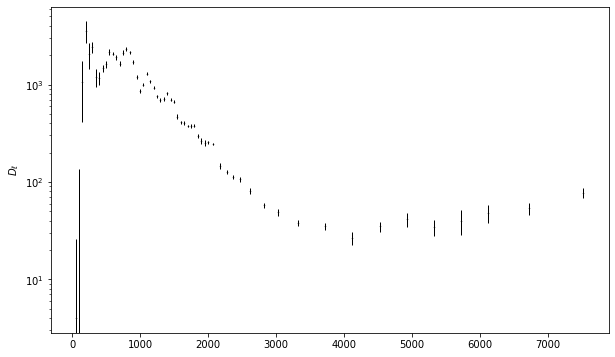

In [18]:
fig, axes = plt.subplots(1,1, figsize=(10,6), sharex=True)

# plot our spectra
lb = mc.lb

plt.errorbar(lb, mean_Dltt,
                 fmt='k.', 
                 yerr=(mean_Dltt / np.sqrt(2*lb+1) + se_Dltt),
                 lw=1, ms=1)
plt.ylabel(r"$D_{\ell}$")
plt.yscale('log')


The errorbars above are a good quick approximation. A better estimate can be obtained using the analytic covariance matrices, which is more computationally intensive.

### Analytic Covariance Matrices


Above, we estimated the covariance matrix from the standard error of the six split cross-spectra. We can instead estimate this analytically. To do a full error analysis we would want to include information from the simulations as well as systematic errors.  However, we can still improve on the standard error estimation above by including information from the four splits. 

In this case we only have one mask, which simplifies things a lot. If you assume each split has the same covariance matrix, then you only need to compute two covariances: the auto-spectrum and the cross-spectrum.

By default, nawrapper will estimate the noise power spectrum using step functions.

In [11]:
test = nw.nacov(namap_list[0], namap_list[1], mc, mc, mc)

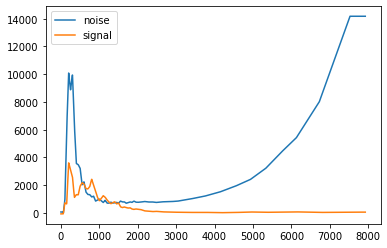

In [12]:
plt.plot(test.noise['T1T1'], label='noise')
plt.plot(test.signal['TT'], label='signal')
plt.legend()

Essentially you need to know the noise and signal cross-spectra. Since covariance is a bilinear map, the mean of six cross-spectra follows the expressions below.


In [13]:
cross_cov = nw.compute_covmat(namap_list[0], namap_list[1], bins,mc_11=mc, mc_12=mc, mc_22=mc)
auto_cov = nw.compute_covmat(namap_list[0], namap_list[0], bins, mc_11=mc, mc_12=mc, mc_22=mc)


These covariance results are just dictionaries containing keys to the covariance matrices, which you can access via something like `cross_cov['TTTT']`. We'll now combine them to calculate the mean covariance matrix.

In [14]:
from scipy.special import comb

# compute the number of TT cross-spectra from the number of splits
n_spec = comb(nsplits, 2)

# weight auto and cross covmats to get mean covmat
cross_weight = n_spec**2 - n_spec
auto_weight = n_spec
combined_TT_cov = (cross_cov['TTTT']*cross_weight/n_spec + auto_cov['TTTT']*auto_weight/n_spec)/(n_spec**2)


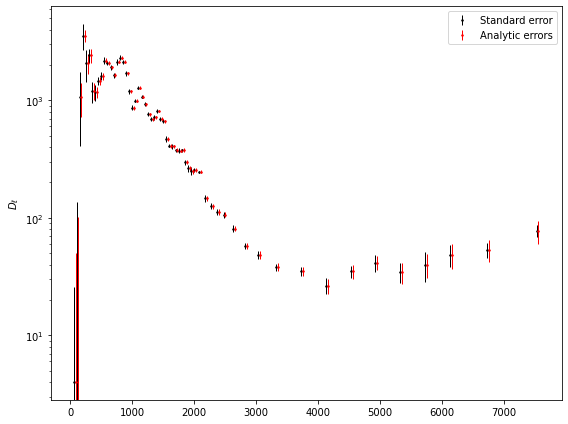

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharex=True)

# plot our spectra
lb = mc.lb
ax.errorbar(lb, mean_Dltt,
            fmt='k.', 
            yerr=(mean_Dltt / np.sqrt(2 * lb + 1) + se_Dltt),
            lw=1, ms=3, label="Standard error")
ax.errorbar(lb + 30, mean_Dltt, # we slightly offset to not overlap
            fmt='r.', 
            yerr=np.sqrt(np.diag(combined_TT_cov)) / (lb * (lb+1) / 2 / np.pi),
            lw=1, ms=3, label="Analytic errors")
ax.set_ylabel(r"$D_{\ell}$")
ax.legend(frameon=True)
plt.yscale('log')
plt.tight_layout()

Note that the errors here do not include any corrections systematic errors that would be due to the window function, calibration, or mapmaking transfer function uncertainty. In Choi et al 2020 these corrections are applied after coadding the power spectra over seasons and arrays.

In [ ]:
# Continue to next section